In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

from scipy.fft import fft, ifft

In [7]:
# %config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns
sns.set_style('white')

import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt

In [8]:
data = pd.read_csv('../data/train.csv')
data.head()

,id,time,x,y
0,1,0,800,0
1,1,780,780,0
2,1,1572,792,0
3,1,2392,820,0
4,1,3196,804,0


In [9]:
# #для нейронок
# scaler = StandardScaler()
# scaler.fit(data.x.to_numpy().reshape(-1, 1))
# data.x = scaler.transform(data.x.to_numpy().reshape(-1, 1))
# data.head()

In [10]:
test = pd.read_csv('../data/test.csv')
test['y'] = 0
test.head()

,id,time,x,y
0,81,0,576,0
1,81,568,568,0
2,81,1140,572,0
3,81,1716,576,0
4,81,2284,568,0


In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook


features = [
            'x',
            'x_diff_1', 'x_diff_2','x_diff_3','x_diff_4',#'x_diff_5','x_diff_6',#'time_diff',
            'norm_diff_1', 'norm_diff_2','norm_diff_3','norm_diff_4',
            'mean_2','mean_4','mean_6',# 'mean_20', 'mean_50',
            'std_2','std_4','std_6', #'std_20', 'std_50',
            'norm_2','norm_4','norm_6', #'norm_20', 'norm_50',
            'diff_with_mean_2','diff_with_mean_4','diff_with_mean_6',
            'add_std_2', 'minus_std_2', 'add_2std_2', 'minus_2std_2', 'add_15std_2', 'minus_15std_2',
            'add_std_4', 'minus_std_4', 'add_2std_4', 'minus_2std_4', 'add_15std_4', 'minus_15std_4',
            'add_std_6', 'minus_std_6', 'add_2std_6', 'minus_2std_6', 'add_15std_6', 'minus_15std_6',
            'x_log_relative', 'rolling_mean', 'rolling_mean_rel'
]

CHUNK_LEN = 10
def process_df(df, _id, chunk_len=32, aug=False):
        seq_df = df[df.id==_id].reset_index(drop=True)
        if aug:
            seq_df.x = add_noize(seq_df.x.values)  
#         print(seq_df.shape)
#         print(seq_df.columns)
# ['id', 'time', 'x', 'y'],
        x1 = np.mean(seq_df.x.values[:20])
        x2 = np.mean(seq_df.x.values[-20:])
        t0 = seq_df.time.values[0]
        t1 = seq_df.time.values[-1]
        start_df = []
        for i in range(chunk_len // 2):
            start_df.insert(0, [_id, t0 - (i+1) * 600, x1, 0])
        end_df = []
        for i in range(chunk_len // 2):
            end_df.append([_id, t1 + (i+1) * 600, x2, 0])
        start_df = pd.DataFrame(start_df, columns=['id', 'time', 'x', 'y'])
        end_df = pd.DataFrame(end_df, columns=['id', 'time', 'x', 'y'])
        seq_df = pd.concat([start_df, seq_df, end_df])
#         print(seq_df.shape)
    
        
        seq_df['x_relative'] = seq_df.x / seq_df.x.shift(1)
        seq_df['x_log_relative'] = np.log(seq_df['x_relative'])
        seq_df = seq_df.fillna(method='ffill')
        
        seq_df['rolling_mean'] = seq_df['x'].rolling(window=5).max()
        seq_df['rolling_mean_rel'] = seq_df['x_log_relative'].rolling(window=5).max()
        
        seq_df['time_diff'] = seq_df.time.diff()
        for i in range(12):
            seq_df[f'x_diff_{i + 1}'] = seq_df.x.diff(i + 1).fillna(0)
        for i in range(12):
            seq_df[f'x_diff_front_{i + 1}'] = seq_df.x.diff(-(i + 1)).fillna(0)
    #################################### скользящие средние и дисперсии ###########################
        sizes = [2, 4, 6, 20, 50]
        for i in sizes:
            m, s = sliding(seq_df.x.values, i)
            seq_df[f'mean_{i}'] = m
            seq_df[f'std_{i}'] = s
#             seq_df[f'add_std_{i}'] = np.array(seq_df.x.values) + np.array(s)
#             seq_df[f'minus_std_{i}'] = np.array(seq_df.x.values) - np.array(s)
#             seq_df[f'add_2std_{i}'] = np.array(seq_df.x.values) + (np.array(s) / 2)
#             seq_df[f'minus_2std_{i}'] = np.array(seq_df.x.values) - (np.array(s) / 2)
            seq_df[f'add_std_{i}'] = (np.array(m) + np.array(s)) - np.array(seq_df.x.values)
            seq_df[f'minus_std_{i}'] = np.array(seq_df.x.values) - (np.array(m) - np.array(s))
            seq_df[f'add_2std_{i}'] = (np.array(m) + np.array(s)/2) - np.array(seq_df.x.values)
            seq_df[f'minus_2std_{i}'] = np.array(seq_df.x.values) - (np.array(m) - np.array(s)/2)
            seq_df[f'add_15std_{i}'] = (np.array(m) + 1.5*np.array(s)) - np.array(seq_df.x.values)
            seq_df[f'minus_15std_{i}'] = np.array(seq_df.x.values) - (np.array(m) - 1.5*np.array(s))
            seq_df[f'norm_{i}'] = (seq_df.x.values - np.array(m)) / (np.array(s) + 1e-3)
            seq_df[f'diff_with_mean_{i}'] = seq_df.x.values - np.array(m)
        
        for i in range(12):
            seq_df[f'norm_diff_{i + 1}'] = seq_df['norm_6'].diff(i + 1).fillna(0)
        for i in range(12):
            seq_df[f'norm_diff_front_{i + 1}'] = seq_df['norm_6'].diff(-(i + 1)).fillna(0)
        return seq_df
def add_noize(a):
    return a + np.random.normal(0,10, len(a))
def get_check(df, _id,
                      chunk_len=32, 
                      is_one_hot_y=False,
                      x_column='x',
                      y_column='y',
                      N_CLASS=2,
                     ):
    X = []
    Y = []
    id2process_dct = {}
    seq_ids = list(df.id.unique())
    #for _id in tqdm_notebook(seq_ids):
    
    seq_df = process_df(df, _id, chunk_len=CHUNK_LEN)
    id2process_dct[_id] = seq_df 
        
#     for seq_id in tqdm_notebook(seq_ids):
    seq_id = _id
    seq_df = id2process_dct[seq_id]
    seq_df = seq_df.fillna(0)
    seq_len = len(seq_df)
#     n_slices = seq_len // chunk_len

    for i in range(len(seq_df) - chunk_len):
        slice_df = seq_df.iloc[i:i+chunk_len]
        X.append(slice_df[features].values)
        y = slice_df['y'].tolist()[len(slice_df) // 2]
        if is_one_hot_y:
            y = tf.keras.utils.to_categorical(y, num_classes=N_CLASS, dtype='float32')
        Y.append(y)


    X = np.array(X, dtype='float32')
    Y = np.array(Y, dtype='int')
    return seq_df.time.values, X, seq_df.x.values, seq_df.y.values

def get_smart_dataset(df, seq_ids_train, seq_ids_val, seq_ids_test,
                      chunk_len=32, 
                      is_one_hot_y=False,
                      x_column='x',
                      y_column='y',
                      N_CLASS=2,
                     ):
    X_train, X_val, X_test = [], [], []
    Y_train, Y_val, Y_test = [], [], []
    id2process_dct = {}
    
#     seq_ids = list(df.id.unique())
#     t1, t2 = int(0.7*len(seq_ids)), int(0.9*len(seq_ids))
#     seq_ids_train = seq_ids[:t1]
#     seq_ids_val = seq_ids[t1:t2]
#     seq_ids_test = seq_ids[t2:]
    
#     for _id in tqdm_notebook(seq_ids):
#         seq_df = process_df(df, _id)
                
#         id2process_dct[_id] = seq_df 
     
    #### train
    for seq_id in tqdm_notebook(seq_ids_train):
    
#         seq_df = id2process_dct[seq_id]
        seq_df = process_df(df, seq_id, chunk_len=CHUNK_LEN)
        seq_df = seq_df.fillna(0)
        seq_len = len(seq_df)
        n_slices = seq_len // chunk_len

        for i in range(len(seq_df) - chunk_len):
            slice_df = seq_df.iloc[i:i+chunk_len]
            X_train.append(slice_df[features].values)
            y = slice_df['y'].tolist()[len(slice_df) // 2]
#             if is_one_hot_y:
#                 y = tf.keras.utils.to_categorical(y, num_classes=N_CLASS, dtype='float32')
            Y_train.append(y)
            
#         ################## aug
#         for i in range(10):
#             seq_df = process_df(df, seq_id, aug=True)
#             seq_len = len(seq_df)
#             n_slices = seq_len // chunk_len

#             for i in range(len(seq_df) - chunk_len):
#                 slice_df = seq_df.iloc[i:i+chunk_len]
#                 X_train.append(slice_df[features].values)
#                 y = slice_df['y'].tolist()[len(slice_df) // 2]
# #                 if is_one_hot_y:
# #                     y = tf.keras.utils.to_categorical(y, num_classes=N_CLASS, dtype='float32')
#                 Y_train.append(y)
        #######################
    ##### val
    for seq_id in tqdm_notebook(seq_ids_val):
    
#         seq_df = id2process_dct[seq_id]
        seq_df = process_df(df, seq_id, chunk_len=CHUNK_LEN)
        seq_df = seq_df.fillna(0)
        seq_len = len(seq_df)
        n_slices = seq_len // chunk_len

        for i in range(len(seq_df) - chunk_len):
            slice_df = seq_df.iloc[i:i+chunk_len]
            X_val.append(slice_df[features].values)
            y = slice_df['y'].tolist()[len(slice_df) // 2]
#             if is_one_hot_y:
#                 y = tf.keras.utils.to_categorical(y, num_classes=N_CLASS, dtype='float32')
            Y_val.append(y)

            
    #### test
    for seq_id in tqdm_notebook(seq_ids_test):
    
#         seq_df = id2process_dct[seq_id]
        seq_df = process_df(df, seq_id, chunk_len=CHUNK_LEN)
        seq_df = seq_df.fillna(0)
        seq_len = len(seq_df)
        n_slices = seq_len // chunk_len

        for i in range(len(seq_df) - chunk_len):
            slice_df = seq_df.iloc[i:i+chunk_len]
            X_test.append(slice_df[features].values)
            y = slice_df['y'].tolist()[len(slice_df) // 2]
#             if is_one_hot_y:
#                 y = tf.keras.utils.to_categorical(y, num_classes=N_CLASS, dtype='float32')
            Y_test.append(y)

    X_train = np.array(X_train, dtype='float32')
    Y_train = np.array(Y_train, dtype='int')
    X_val = np.array(X_val, dtype='float32')
    Y_val = np.array(Y_val, dtype='int')
    X_test = np.array(X_test, dtype='float32')
    Y_test = np.array(Y_test, dtype='int')
    return X_train, Y_train, X_val, Y_val, X_test, Y_test, seq_ids_train, seq_ids_val, seq_ids_test

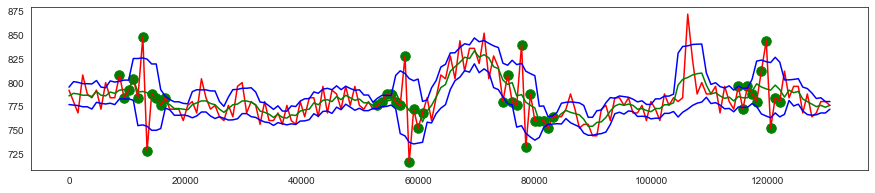

In [13]:
def sliding(x, len_):
    x = [x[0]] * (len_ // 2) + list(x) + [x[-1]] * (len_ // 2)
    mean, std = [], []
    for i in range(0, len(x)-len_, 1):
#         print()
        mean.append(np.mean(x[i : i+len_]))
        std.append(np.std(x[i : i+len_]))
    return mean, std

x = data[data.id == 6].x.values
time = data[data.id == 6].time.values
y = data[data.id == 6].y.values
mean, std = sliding(x, 6)

plt.figure(figsize=(15,3))
plt.plot(time, x, 'r')
plt.plot(time, mean, 'g')
plt.scatter(time[y == 1], x[y == 1], s=90, c='g', label='gt')
plt.plot(time, np.array(mean) - np.array(std), 'b')
plt.plot(time, np.array(mean) + np.array(std), 'b')
plt.show()

In [14]:
seq_ids = list(data.id.unique())
np.random.shuffle(seq_ids)
# print(seq_ids)
t1, t2 = int(0.7*len(seq_ids)), int(0.9*len(seq_ids))
seq_ids_train = seq_ids#[:t1]
seq_ids_val = seq_ids[t1:t2]
seq_ids_test = seq_ids[t2:]

x_train, y_train, x_val, y_val, x_test, y_test, seq_ids_train, seq_ids_val, seq_ids_test = get_smart_dataset(data, seq_ids_train, seq_ids_val, seq_ids_test, chunk_len=CHUNK_LEN)
print(x_train.shape, y_train.shape)

C:\Users\vadik\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:194: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\vadik\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:225: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\vadik\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:243: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(60487, 10, 42) (60487,)


In [15]:
print(x_train.shape)
x_train = x_train[:x_train.shape[0] // 2, :, :]
print(x_train.shape)

(60487, 10, 42)
(30243, 10, 42)


In [21]:
from sklearn.decomposition import PCA


pca_transformer = PCA(n_components=5).fit(x_train[:,:, 0])
X_pca = pca_transformer.transform(x_train[:,:, 0])
print(f'Explained info: {round(sum(pca_transformer.explained_variance_ratio_)*100)}%')

# df['PCA_1'] = X_pca[:, 0]
# df['PCA_2'] = X_pca[:, 1]
# df['PCA_3'] = X_pca[:, 2]
# X_pca.shape, x_train.shape, X.shape

Explained info: 73.0%


In [22]:
import pickle

WEIGHTS_FOLDER = '../main/weights/12.07.21'

pca_filename = 'pca.pkl' 

with open(os.path.join(WEIGHTS_FOLDER, pca_filename), 'wb') as pickle_file:
    pickle.dump(pca_transformer, pickle_file)

In [23]:
X_val_pca = pca_transformer.transform(x_val[:,:, 0])
X_test_pca = pca_transformer.transform(x_test[:,:, 0])

In [24]:
# x_train = np.array(x_train)
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1] *x_train.shape[2] ))
# y_train = np.array(y_train)
# x_val = np.array(x_val)
x_val = x_val.reshape((x_val.shape[0],x_val.shape[1] *x_val.shape[2] ))
# y_val = np.array(y_val)
# x_test = np.array(x_test)
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1] *x_test.shape[2] ))
# y_test = np.array(y_test)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(30243, 420) (60487,)
(9724, 420) (9724,)
(4102, 420) (4102,)


In [25]:
x_train = x_train.tolist()
for i in range(len(X_pca)):
    x_train[i].extend(X_pca[i])
x_train = np.array(x_train)
x_train.shape

(30243, 425)

In [26]:
x_val = x_val.tolist()
for i in range(len(X_val_pca)):
    x_val[i].extend(X_val_pca[i])
x_val = np.array(x_val)
x_val.shape

(9724, 425)

In [27]:
x_test = x_test.tolist()
for i in range(len(X_test_pca)):
    x_test[i].extend(X_test_pca[i])
x_test = np.array(x_test)
x_test.shape

(4102, 425)

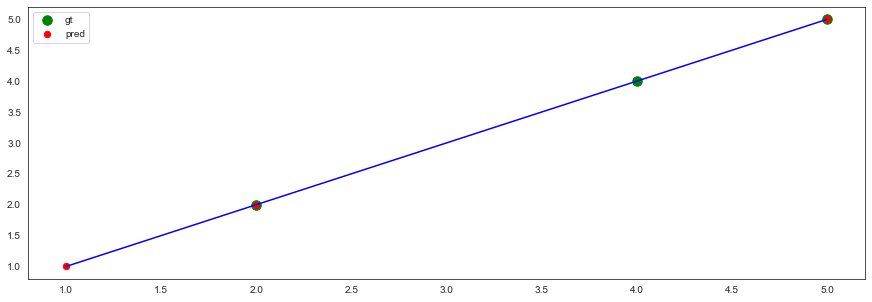

In [28]:
def plot_res(time, x, gt=None, pred=None):
    t1, t2 = int(0.7*len(x)), int(0.9*len(x))
    t1, t2 = time[t1], time[t2]
    
    plt.figure(figsize=(15, 5))
#     plt.axvline(t1, c='black', label='train/val/test')
#     plt.axvline(t2, c='black')
    plt.plot(time, x, 'b-')
    plt.scatter(time[gt == 1], x[gt == 1], s=90, c='g', label='gt')
    plt.scatter(time[pred == 1], x[pred == 1], s=40, c='r', label='pred')
    plt.legend(loc='best')
    plt.show()
    #plt.save(...)
 
plot_res(np.array([1,2,3,4,5]), np.array([1,2,3,4,5]), gt=np.array([0,1,0,1,1]), pred=np.array([1,1,0,0,1]))

In [29]:
def add_noize(a):
    return a + np.random.normal(0,10, len(a))

In [32]:
# !pip install catboost
from catboost import CatBoostRegressor, Pool, CatBoostClassifier

In [33]:
from catboost.metrics import F1
f1_custom = F1(use_weights=False)

In [34]:
dataset_val = Pool(x_val, y_val)
dataset_test = Pool(x_test, y_test)
# взвесить классы!
model = CatBoostClassifier(iterations=1000,
#                           learning_rate=0.1,
#                           depth=5,
#                         max_depth=7,
#                          n_estimators=1000,
#                            l2_leaf_reg=2,
#                            bootstrap_type='Bernoulli',
                           use_best_model=True,
                           class_weights=[0.143, 1-0.143],
#                          loss_function='RMSE',
#                          eval_metric='F1', #'AUC',
                           eval_metric=f1_custom,
                           metric_period=100,
                          border_count=90, #.21905885520627, 
                           depth=5.0, 
                           l2_leaf_reg=5.1068065853115385, 
                           learning_rate=0.12611248771381028
                          )

model.fit(x_train, y_train[:len(y_train)//2],  eval_set=[dataset_val, dataset_test])

0:	learn: 0.5218784	test: 0.5937373	test1: 0.6061107	best: 0.6061107 (0)	total: 125ms	remaining: 2m 4s
100:	learn: 0.7839542	test: 0.8105344	test1: 0.8186583	best: 0.8186583 (100)	total: 3.78s	remaining: 33.6s
200:	learn: 0.8377867	test: 0.8274232	test1: 0.8375883	best: 0.8375883 (200)	total: 7.27s	remaining: 28.9s
300:	learn: 0.8727405	test: 0.8295424	test1: 0.8435072	best: 0.8435072 (300)	total: 10.7s	remaining: 24.8s
400:	learn: 0.8982273	test: 0.8299430	test1: 0.8513514	best: 0.8513514 (400)	total: 14.5s	remaining: 21.7s
500:	learn: 0.9218452	test: 0.8320569	test1: 0.8522533	best: 0.8522533 (500)	total: 19s	remaining: 18.9s
600:	learn: 0.9394096	test: 0.8281768	test1: 0.8535325	best: 0.8535325 (600)	total: 23.3s	remaining: 15.5s
700:	learn: 0.9519811	test: 0.8270510	test1: 0.8525159	best: 0.8535325 (600)	total: 27.7s	remaining: 11.8s
800:	learn: 0.9648936	test: 0.8276631	test1: 0.8513357	best: 0.8535325 (600)	total: 32s	remaining: 7.95s
900:	learn: 0.9733065	test: 0.8284355	test1: 

In [35]:
weights_filename = 'cardiospike.cbm'
model.save_model(os.path.join(WEIGHTS_FOLDER, weights_filename))

# Предсказание

In [36]:

# seq_ids_train, seq_ids_val, seq_ids_test 
for id_ in tqdm(test.id.unique()):
    print(id_)
#     time, x, x_data, y = get_slices_check(id_, len_=10)
    time, x_data, x, y = get_check(test, id_, chunk_len=CHUNK_LEN) 
    pca = pca_transformer.transform(x_data[:,:, 0])
    x_data = x_data.reshape((x_data.shape[0],x_data.shape[1] *x_data.shape[2] ))
    
    x_data = x_data.tolist()
    for i in range(len(pca)):
        x_data[i].extend(pca[i])
    x_data = np.array(x_data)

    pred = model.predict(x_data)#[11:-11]
    
    
    test.y[test.id == id_] = pred 
#     pred = [0,0,0,0,0] + list(pred) + [0,0,0,0,0]
    pred = np.array(pred)
#     print(pred)
#     print(len(test[test.id == id_]), len(x_data), len(pred))
#     print(time.shape,x_data.shape, x.shape, y.shape, pred.shape)
#     plot_res(test[test.id == id_].time.values, test[test.id == id_].x.values, 
#              gt=test[test.id == id_].y.values, pred=pred)

81
168
243
135
9
11
157
212
166
154
227
165
37
274
211
200
183
26
175
50
141
198
114
181
171
83
8
256
249
142
210
106
248
255
28
192
18
267
105
95
94
269
56
98
184
176

